In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'test pytorch sac empirical blend 2'
Experiment_note = """
"""

In [5]:
gpuId = 1
frame_skip = 200
theta = np.array([-180,180])
vel_theta = np.array([-180,180])
random_vel =np.array([0,0.5])
radius=2.0
max_time = 10
action_max= 13
couple_mode =  fl.COUPLE_MODE.EMPIRICAL
ratio = 5/frame_skip*(max_time/10)
import torch
torch.cuda.set_device(gpuId)

In [6]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda:"+str(gpuId)
# logger
log_frequency=1
log_save_tb=True
# video recorder
save_video=False
seed=1

In [7]:

discount=0.99
init_temperature=0.1
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
actor_update_frequency=1
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
critic_target_update_frequency=2
batch_size=int(2048*ratio)
learnable_temperature=True

# critic settings
critic_hidden_dim=128
critic_hidden_depth=2
# actor settings
actor_hidden_depth=2
actor_hidden_dim=128
actor_log_std_bounds=[-5, 2]

evaluate_save_data = False
evaluate_save_fluid = False



In [8]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [9]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [10]:
fluid_json = json_folder+'fluid_param_1.0.json'
rigid_json = json_folder+'rigids_4_30.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_1.0.json
/root/pytorch_fish/py_data/jsons/rigids_4_30.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [11]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [12]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [13]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer
from sac.agent import utils
import warnings
warnings.filterwarnings("ignore", message="Setting attributes on ParameterList is not supported.")

## RL Begin

In [15]:
from sac.agent.sac import SACAgent
from sac.agent.critic import DoubleQCritic
from sac.agent.actor import DiagGaussianActor
from sac.agent.actor_blend import DiagGaussianActor_Blend

In [16]:
from gym_fish.envs import FishEnv
env = gym.make('fish-v0', 
                  gpuId=gpuId,
                       path_json=path_json,
                        couple_mode=couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=1.0,wr=0.0,wa=0.00,
                       rigid_json=rigid_json,vel_theta = vel_theta
                   )
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_range=[
        float(env.action_space.low.min()),
        float(env.action_space.high.max())
    ] # to be specified later
env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()

array([ 0.99363307, -0.00801926, -0.11237885])

In [17]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

#### load base actors and memories

In [18]:

base_folders = [
    '/root/pytorch_fish/output_data/2021-03-16/test pytorch sac empirical 45-135_2021-03-16 11:08/networks/SAC/models/',
    '/root/pytorch_fish/output_data/2021-03-16/test pytorch sac empirical -45 -135_2021-03-16 11:08/networks/SAC/models/',
#     '/root/pytorch_fish/output_data/2021-03-15/test pytorch sac empirical_2021-03-15 20:12/networks/SAC/models/',
]
actors = [torch.load(base_folders[i]+'actor',map_location=torch.device('cpu'))['actor'] for i in range(len(base_folders))]
# for key, value in actors[0].items(): 
#     for a in actors:
#         a[key]=a[key].cpu()



# memories = [ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device) for i in range(len(base_folders))]
# for i in range(len(base_folders)):
#     memories[i]=torch.load(base_folders[i]+'buffer')['buffer']

#### unite buffers

In [19]:
replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,replay_buffer_capacity,device)

# replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity)*len(base_folders),device)

# for buffer in memories:
#     for i in range(0,buffer.capacity):
#         replay_buffer.add(buffer.obses[i],buffer.actions[i],buffer.rewards[i],buffer.next_obses[i],buffer.not_dones[i],buffer.not_dones_no_max[i])


In [20]:
logger = Logger(tb_folder,
                             save_tb=log_save_tb,
                             log_frequency=log_frequency,
                             agent="sac")
critic_network = DoubleQCritic(obs_dim,action_dim,critic_hidden_dim,critic_hidden_depth)


In [21]:
# actor_network = DiagGaussianActor(obs_dim,action_dim,actor_hidden_dim,actor_hidden_depth,actor_log_std_bounds)

actor_network = DiagGaussianActor_Blend(obs_dim,action_dim, actor_hidden_dim, actor_hidden_depth,actor_log_std_bounds,base_policy_param_dicts =actors)

In [22]:
# actor_network.gate_network.forward(torch.Tensor(env._get_obs()).to(device))

In [23]:

agent = SACAgent(obs_dim,action_dim,action_range,device,critic_network,actor_network,replay_buffer,discount,init_temperature,alpha_lr,alpha_betas,actor_lr,actor_betas,actor_update_frequency,critic_lr,critic_betas,critic_tau,critic_target_update_frequency,batch_size,learnable_temperature)

utils.set_seed_everywhere(seed)

In [24]:
step = 0
next_eval_steps= eval_frequency

In [25]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                with utils.eval_mode(agent):
                        action = agent.act(obs, sample=True)
            next_obs, reward, done, _ = env.step(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [26]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [27]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode at step {} episode {}".format(step,episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                with utils.eval_mode(agent):
                    action = agent.act(obs, sample=False)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [28]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


Collect seed samples complete. Step:  51  Seed steps: 51
| train | E: 1 | S: 49 | R: 10.4853 | D: 59.5 s | BR: -0.0932 | ALOSS: 0.4600 | CLOSS: 0.2292 | TLOSS: 0.3950 | TVAL: 0.0993 | AENT: -0.0213
| train | E: 2 | S: 99 | R: 8.6688 | D: 60.8 s | BR: 0.0240 | ALOSS: 0.5991 | CLOSS: 0.2473 | TLOSS: 0.3828 | TVAL: 0.0978 | AENT: -0.0868
| train | E: 3 | S: 149 | R: 19.6452 | D: 63.8 s | BR: 0.0823 | ALOSS: -0.2832 | CLOSS: 0.2954 | TLOSS: 0.3693 | TVAL: 0.0964 | AENT: -0.1702
| train | E: 4 | S: 199 | R: 2.5056 | D: 60.1 s | BR: 0.1334 | ALOSS: -2.4475 | CLOSS: 0.5381 | TLOSS: 0.3545 | TVAL: 0.0950 | AENT: -0.2703
| train | E: 5 | S: 249 | R: 11.4683 | D: 58.7 s | BR: 0.1348 | ALOSS: -5.9419 | CLOSS: 2.1523 | TLOSS: 0.3318 | TVAL: 0.0937 | AENT: -0.4604
| train | E: 6 | S: 299 | R: 0.9726 | D: 61.1 s | BR: 0.1349 | ALOSS: -10.2308 | CLOSS: 4.5977 | TLOSS: 0.2869 | TVAL: 0.0925 | AENT: -0.8995
| train | E: 7 | S: 349 | R: 24.0306 | D: 61.0 s | BR: 0.1470 | ALOSS: -12.6453 | CLOSS: 5.8085 

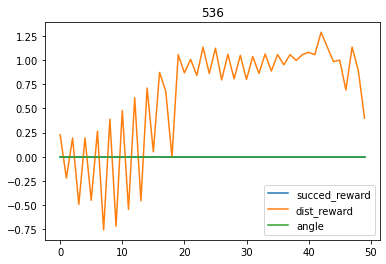

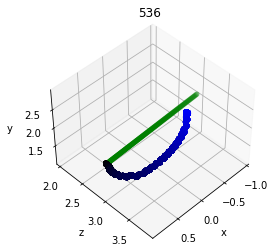

| eval  | E: 10 | S: 536 | R: 30.9993
| train | E: 11 | S: 536 | R: 32.1326 | D: 54.5 s | BR: 0.2609 | ALOSS: -41.5275 | CLOSS: 70.5176 | TLOSS: 0.0359 | TVAL: 0.0896 | AENT: -3.5990
| train | E: 12 | S: 574 | R: 33.0607 | D: 108.3 s | BR: 0.3049 | ALOSS: -39.0548 | CLOSS: 55.9172 | TLOSS: 0.0380 | TVAL: 0.0895 | AENT: -3.5749
| train | E: 13 | S: 613 | R: 32.1128 | D: 48.7 s | BR: 0.3203 | ALOSS: -35.9320 | CLOSS: 42.5006 | TLOSS: 0.0251 | TVAL: 0.0893 | AENT: -3.7188
| train | E: 14 | S: 652 | R: 33.2294 | D: 46.1 s | BR: 0.3499 | ALOSS: -29.3581 | CLOSS: 32.0168 | TLOSS: 0.0305 | TVAL: 0.0892 | AENT: -3.6581
| train | E: 15 | S: 699 | R: 32.4339 | D: 56.4 s | BR: 0.3750 | ALOSS: -23.6628 | CLOSS: 22.3157 | TLOSS: 0.0324 | TVAL: 0.0891 | AENT: -3.6361
| train | E: 16 | S: 736 | R: 32.5066 | D: 43.6 s | BR: 0.4120 | ALOSS: -19.1557 | CLOSS: 16.3002 | TLOSS: 0.0386 | TVAL: 0.0889 | AENT: -3.5656
| train | E: 17 | S: 774 | R: 33.1108 | D: 44.6 s | BR: 0.4408 | ALOSS: -14.7419 | CLOSS: 1

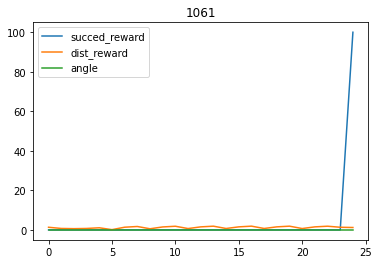

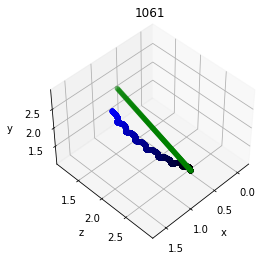

| eval  | E: 23 | S: 1061 | R: 30.8502
| train | E: 24 | S: 1061 | R: 9.3009 | D: 61.2 s | BR: 0.5073 | ALOSS: -10.8151 | CLOSS: 5.2114 | TLOSS: 0.1287 | TVAL: 0.0853 | AENT: -2.4925
| train | E: 25 | S: 1086 | R: 32.2660 | D: 60.6 s | BR: 0.5214 | ALOSS: -12.4259 | CLOSS: 5.7252 | TLOSS: 0.1216 | TVAL: 0.0847 | AENT: -2.5644
| train | E: 26 | S: 1121 | R: 28.8023 | D: 41.8 s | BR: 0.5425 | ALOSS: -14.0186 | CLOSS: 5.9391 | TLOSS: 0.1037 | TVAL: 0.0842 | AENT: -2.7680
| train | E: 27 | S: 1148 | R: 30.2773 | D: 33.7 s | BR: 0.5259 | ALOSS: -15.5730 | CLOSS: 7.6639 | TLOSS: 0.0985 | TVAL: 0.0837 | AENT: -2.8239
| train | E: 28 | S: 1175 | R: 31.0325 | D: 33.6 s | BR: 0.5469 | ALOSS: -16.2276 | CLOSS: 10.0958 | TLOSS: 0.0969 | TVAL: 0.0833 | AENT: -2.8368
| train | E: 29 | S: 1207 | R: 32.1009 | D: 37.6 s | BR: 0.5582 | ALOSS: -16.6414 | CLOSS: 8.1579 | TLOSS: 0.0932 | TVAL: 0.0829 | AENT: -2.8763
| train | E: 30 | S: 1235 | R: 31.1702 | D: 33.7 s | BR: 0.5624 | ALOSS: -17.2414 | CLOSS: 

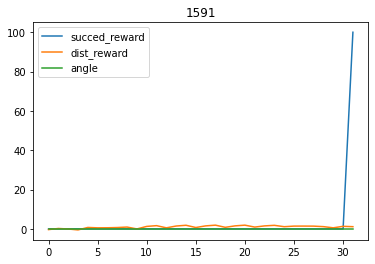

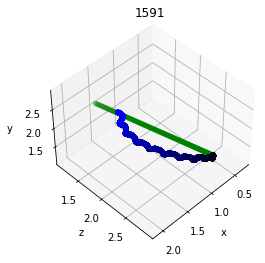

| eval  | E: 40 | S: 1591 | R: 32.1622
| train | E: 41 | S: 1591 | R: 32.4961 | D: 42.1 s | BR: 0.6473 | ALOSS: -13.8967 | CLOSS: 5.3494 | TLOSS: 0.0649 | TVAL: 0.0781 | AENT: -3.1695
| train | E: 42 | S: 1620 | R: 31.5662 | D: 72.1 s | BR: 0.6495 | ALOSS: -13.5778 | CLOSS: 6.2214 | TLOSS: 0.0525 | TVAL: 0.0778 | AENT: -3.3253
| train | E: 43 | S: 1652 | R: 29.1716 | D: 38.0 s | BR: 0.6848 | ALOSS: -13.7936 | CLOSS: 3.4142 | TLOSS: 0.0581 | TVAL: 0.0775 | AENT: -3.2508
| train | E: 44 | S: 1702 | R: 13.2100 | D: 60.2 s | BR: 0.6682 | ALOSS: -14.4599 | CLOSS: 5.6176 | TLOSS: 0.0546 | TVAL: 0.0771 | AENT: -3.2916
| train | E: 45 | S: 1741 | R: 29.6431 | D: 45.4 s | BR: 0.6691 | ALOSS: -14.6034 | CLOSS: 4.3174 | TLOSS: 0.0472 | TVAL: 0.0767 | AENT: -3.3849
| train | E: 46 | S: 1770 | R: 33.8132 | D: 35.0 s | BR: 0.6700 | ALOSS: -15.1105 | CLOSS: 5.5567 | TLOSS: 0.0452 | TVAL: 0.0765 | AENT: -3.4087
| train | E: 47 | S: 1797 | R: 31.1156 | D: 33.9 s | BR: 0.6645 | ALOSS: -15.0599 | CLOSS: 

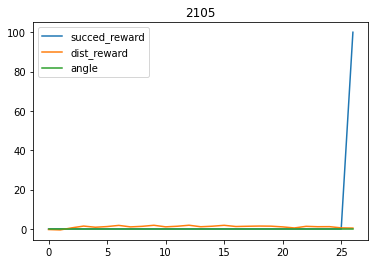

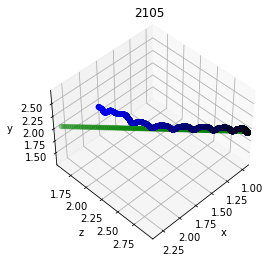

| eval  | E: 55 | S: 2105 | R: 29.8895
| train | E: 56 | S: 2105 | R: 31.8773 | D: 40.6 s | BR: 0.7304 | ALOSS: -13.2297 | CLOSS: 3.8596 | TLOSS: 0.0487 | TVAL: 0.0734 | AENT: -3.3373
| train | E: 57 | S: 2140 | R: 29.7237 | D: 75.3 s | BR: 0.7193 | ALOSS: -13.8350 | CLOSS: 4.6881 | TLOSS: 0.0501 | TVAL: 0.0731 | AENT: -3.3144
| train | E: 58 | S: 2166 | R: 31.5196 | D: 32.2 s | BR: 0.6829 | ALOSS: -13.4892 | CLOSS: 3.9933 | TLOSS: 0.0439 | TVAL: 0.0728 | AENT: -3.3976
| train | E: 59 | S: 2194 | R: 31.6211 | D: 33.0 s | BR: 0.7142 | ALOSS: -13.1591 | CLOSS: 3.3313 | TLOSS: 0.0479 | TVAL: 0.0726 | AENT: -3.3397
| train | E: 60 | S: 2224 | R: 31.8908 | D: 37.4 s | BR: 0.7085 | ALOSS: -13.3247 | CLOSS: 3.5169 | TLOSS: 0.0556 | TVAL: 0.0723 | AENT: -3.2304
| train | E: 61 | S: 2251 | R: 32.2705 | D: 32.5 s | BR: 0.6896 | ALOSS: -13.6210 | CLOSS: 3.9738 | TLOSS: 0.0570 | TVAL: 0.0720 | AENT: -3.2078
| train | E: 62 | S: 2278 | R: 32.4966 | D: 34.2 s | BR: 0.7553 | ALOSS: -14.2652 | CLOSS: 

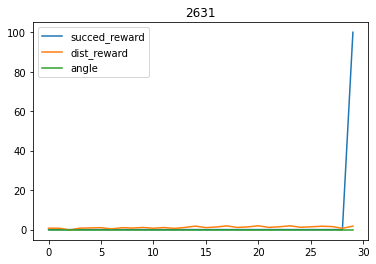

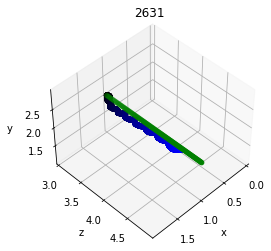

| eval  | E: 72 | S: 2631 | R: 33.2196
| train | E: 73 | S: 2631 | R: 28.4895 | D: 36.8 s | BR: 0.7565 | ALOSS: -12.7535 | CLOSS: 3.0819 | TLOSS: 0.0402 | TVAL: 0.0681 | AENT: -3.4094
| train | E: 74 | S: 2665 | R: 31.1067 | D: 79.3 s | BR: 0.7849 | ALOSS: -13.3997 | CLOSS: 3.5167 | TLOSS: 0.0391 | TVAL: 0.0679 | AENT: -3.4237
| train | E: 75 | S: 2706 | R: 32.9964 | D: 50.3 s | BR: 0.7814 | ALOSS: -13.4844 | CLOSS: 3.1610 | TLOSS: 0.0429 | TVAL: 0.0675 | AENT: -3.3648
| train | E: 76 | S: 2745 | R: 30.7721 | D: 48.8 s | BR: 0.7705 | ALOSS: -13.3096 | CLOSS: 2.9075 | TLOSS: 0.0514 | TVAL: 0.0671 | AENT: -3.2343
| train | E: 77 | S: 2771 | R: 31.3585 | D: 31.0 s | BR: 0.7769 | ALOSS: -14.1456 | CLOSS: 3.1050 | TLOSS: 0.0573 | TVAL: 0.0667 | AENT: -3.1407
| train | E: 78 | S: 2799 | R: 31.9782 | D: 33.7 s | BR: 0.7755 | ALOSS: -14.4215 | CLOSS: 3.7178 | TLOSS: 0.0559 | TVAL: 0.0664 | AENT: -3.1573
| train | E: 79 | S: 2835 | R: 31.9858 | D: 43.7 s | BR: 0.7741 | ALOSS: -14.4732 | CLOSS: 

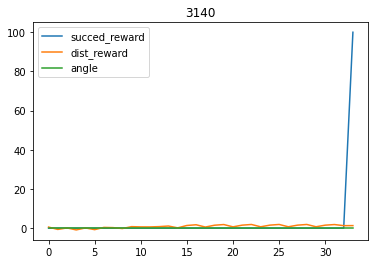

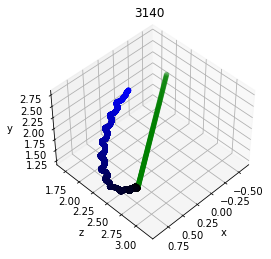

| eval  | E: 87 | S: 3140 | R: 28.9369
| train | E: 88 | S: 3140 | R: 31.4630 | D: 53.4 s | BR: 0.7715 | ALOSS: -15.3482 | CLOSS: 3.4805 | TLOSS: 0.0808 | TVAL: 0.0606 | AENT: -2.6672
| train | E: 89 | S: 3181 | R: 31.8793 | D: 91.1 s | BR: 0.7956 | ALOSS: -14.1712 | CLOSS: 3.4667 | TLOSS: 0.0967 | TVAL: 0.0599 | AENT: -2.3861
| train | E: 90 | S: 3210 | R: 28.5451 | D: 33.7 s | BR: 0.7896 | ALOSS: -14.0634 | CLOSS: 3.7020 | TLOSS: 0.0918 | TVAL: 0.0592 | AENT: -2.4490
| train | E: 91 | S: 3252 | R: 31.2963 | D: 50.3 s | BR: 0.7898 | ALOSS: -13.5169 | CLOSS: 3.3892 | TLOSS: 0.1002 | TVAL: 0.0585 | AENT: -2.2875
| train | E: 92 | S: 3283 | R: 33.1738 | D: 37.6 s | BR: 0.8038 | ALOSS: -15.2922 | CLOSS: 4.2470 | TLOSS: 0.0848 | TVAL: 0.0578 | AENT: -2.5342
| train | E: 93 | S: 3314 | R: 31.8675 | D: 39.5 s | BR: 0.7980 | ALOSS: -14.7701 | CLOSS: 3.5196 | TLOSS: 0.0838 | TVAL: 0.0573 | AENT: -2.5382
| train | E: 94 | S: 3348 | R: 31.3557 | D: 40.2 s | BR: 0.8101 | ALOSS: -14.9567 | CLOSS: 

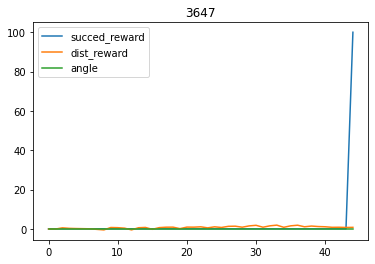

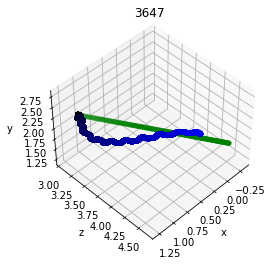

| eval  | E: 102 | S: 3647 | R: 32.5521
| train | E: 103 | S: 3647 | R: 33.0890 | D: 50.9 s | BR: 0.8059 | ALOSS: -15.5450 | CLOSS: 3.2738 | TLOSS: 0.0873 | TVAL: 0.0520 | AENT: -2.3200
| train | E: 104 | S: 3697 | R: 19.5824 | D: 113.8 s | BR: 0.8045 | ALOSS: -14.8286 | CLOSS: 2.5054 | TLOSS: 0.0905 | TVAL: 0.0513 | AENT: -2.2351
| train | E: 105 | S: 3740 | R: 32.9990 | D: 51.6 s | BR: 0.7983 | ALOSS: -15.2415 | CLOSS: 2.5230 | TLOSS: 0.0808 | TVAL: 0.0506 | AENT: -2.4024
| train | E: 106 | S: 3771 | R: 32.7602 | D: 37.3 s | BR: 0.8234 | ALOSS: -15.3521 | CLOSS: 2.5525 | TLOSS: 0.0842 | TVAL: 0.0501 | AENT: -2.3189
| train | E: 107 | S: 3806 | R: 32.1487 | D: 41.5 s | BR: 0.8146 | ALOSS: -14.7451 | CLOSS: 3.2523 | TLOSS: 0.0932 | TVAL: 0.0496 | AENT: -2.1207
| train | E: 108 | S: 3837 | R: 29.8115 | D: 36.8 s | BR: 0.8187 | ALOSS: -14.3810 | CLOSS: 1.9535 | TLOSS: 0.0912 | TVAL: 0.0491 | AENT: -2.1423
| train | E: 109 | S: 3872 | R: 31.8654 | D: 43.8 s | BR: 0.8182 | ALOSS: -14.5151 

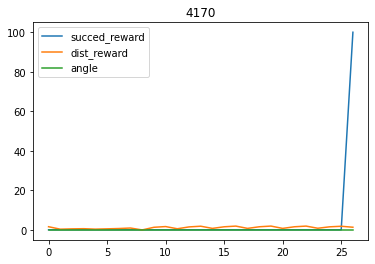

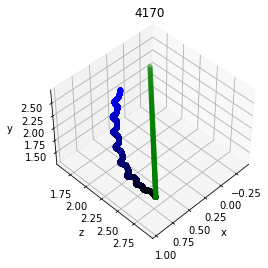

| eval  | E: 116 | S: 4170 | R: 29.8128
| train | E: 117 | S: 4170 | R: 32.4752 | D: 44.7 s | BR: 0.8029 | ALOSS: -15.5277 | CLOSS: 1.2062 | TLOSS: 0.0812 | TVAL: 0.0448 | AENT: -2.1871
| train | E: 118 | S: 4198 | R: 32.0357 | D: 66.4 s | BR: 0.8222 | ALOSS: -14.9199 | CLOSS: 2.1983 | TLOSS: 0.0790 | TVAL: 0.0444 | AENT: -2.2190
| train | E: 119 | S: 4228 | R: 29.7577 | D: 35.6 s | BR: 0.8082 | ALOSS: -14.7969 | CLOSS: 1.7668 | TLOSS: 0.0881 | TVAL: 0.0440 | AENT: -1.9972
| train | E: 120 | S: 4264 | R: 32.8889 | D: 41.9 s | BR: 0.8268 | ALOSS: -15.2994 | CLOSS: 1.4093 | TLOSS: 0.0750 | TVAL: 0.0436 | AENT: -2.2799
| train | E: 121 | S: 4314 | R: 31.3259 | D: 59.6 s | BR: 0.8152 | ALOSS: -14.7973 | CLOSS: 2.5131 | TLOSS: 0.0713 | TVAL: 0.0431 | AENT: -2.3467
| train | E: 122 | S: 4345 | R: 30.9797 | D: 36.6 s | BR: 0.8227 | ALOSS: -14.2280 | CLOSS: 2.0629 | TLOSS: 0.0776 | TVAL: 0.0427 | AENT: -2.1815
| train | E: 123 | S: 4375 | R: 32.9710 | D: 35.6 s | BR: 0.8057 | ALOSS: -14.9521 |

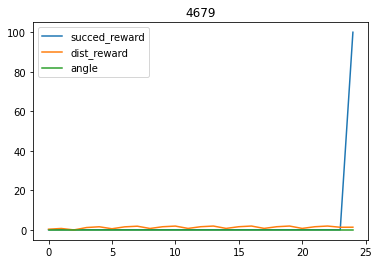

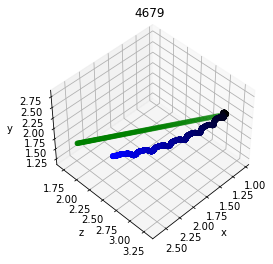

| eval  | E: 131 | S: 4679 | R: 30.2174
| train | E: 132 | S: 4679 | R: 32.7627 | D: 32.5 s | BR: 0.8062 | ALOSS: -15.1787 | CLOSS: 2.8985 | TLOSS: 0.0454 | TVAL: 0.0396 | AENT: -2.8526
| train | E: 133 | S: 4709 | R: 30.7122 | D: 66.7 s | BR: 0.8409 | ALOSS: -14.6576 | CLOSS: 2.3081 | TLOSS: 0.0564 | TVAL: 0.0394 | AENT: -2.5682
| train | E: 134 | S: 4751 | R: 30.2356 | D: 49.6 s | BR: 0.8147 | ALOSS: -15.1821 | CLOSS: 1.5209 | TLOSS: 0.0585 | TVAL: 0.0391 | AENT: -2.5031
| train | E: 135 | S: 4777 | R: 31.7400 | D: 34.9 s | BR: 0.8149 | ALOSS: -15.3862 | CLOSS: 1.8772 | TLOSS: 0.0573 | TVAL: 0.0388 | AENT: -2.5239
| train | E: 136 | S: 4827 | R: 30.0303 | D: 63.4 s | BR: 0.8248 | ALOSS: -14.6597 | CLOSS: 1.7960 | TLOSS: 0.0599 | TVAL: 0.0385 | AENT: -2.4427
| train | E: 137 | S: 4857 | R: 32.1862 | D: 36.9 s | BR: 0.8032 | ALOSS: -14.7479 | CLOSS: 2.6177 | TLOSS: 0.0593 | TVAL: 0.0381 | AENT: -2.4434
| train | E: 138 | S: 4892 | R: 31.3533 | D: 45.2 s | BR: 0.8469 | ALOSS: -14.5699 |

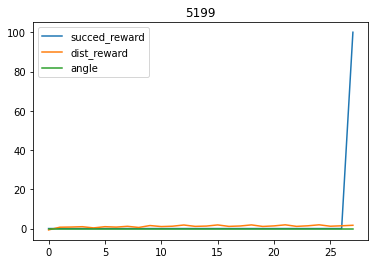

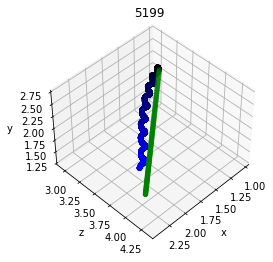

| eval  | E: 146 | S: 5199 | R: 32.3987
| train | E: 147 | S: 5199 | R: 32.6117 | D: 30.1 s | BR: 0.8390 | ALOSS: -15.3143 | CLOSS: 2.4560 | TLOSS: 0.0493 | TVAL: 0.0353 | AENT: -2.6010
| train | E: 148 | S: 5235 | R: 29.2093 | D: 78.2 s | BR: 0.8178 | ALOSS: -15.0899 | CLOSS: 2.5498 | TLOSS: 0.0527 | TVAL: 0.0351 | AENT: -2.4966
| train | E: 149 | S: 5285 | R: 29.8454 | D: 61.6 s | BR: 0.8161 | ALOSS: -14.9927 | CLOSS: 2.5527 | TLOSS: 0.0545 | TVAL: 0.0347 | AENT: -2.4287
| train | E: 150 | S: 5315 | R: 33.3553 | D: 34.0 s | BR: 0.8187 | ALOSS: -14.9218 | CLOSS: 2.3440 | TLOSS: 0.0541 | TVAL: 0.0344 | AENT: -2.4262
| train | E: 151 | S: 5358 | R: 32.8825 | D: 49.3 s | BR: 0.8429 | ALOSS: -16.0706 | CLOSS: 1.8815 | TLOSS: 0.0458 | TVAL: 0.0341 | AENT: -2.6580
| train | E: 152 | S: 5387 | R: 33.7286 | D: 33.5 s | BR: 0.8435 | ALOSS: -14.9019 | CLOSS: 1.3533 | TLOSS: 0.0545 | TVAL: 0.0339 | AENT: -2.3917
| train | E: 153 | S: 5411 | R: 31.9961 | D: 29.0 s | BR: 0.8119 | ALOSS: -15.6209 |

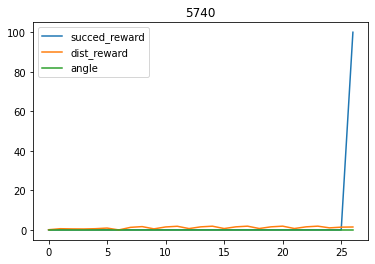

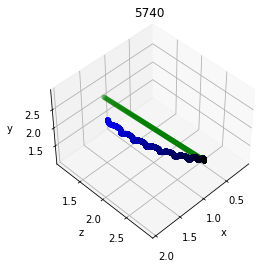

| eval  | E: 161 | S: 5740 | R: 30.2109
| train | E: 162 | S: 5740 | R: 11.0298 | D: 58.4 s | BR: 0.8631 | ALOSS: -15.1301 | CLOSS: 1.7545 | TLOSS: 0.0408 | TVAL: 0.0313 | AENT: -2.6967
| train | E: 163 | S: 5777 | R: 31.7160 | D: 76.1 s | BR: 0.8261 | ALOSS: -14.5330 | CLOSS: 2.4606 | TLOSS: 0.0469 | TVAL: 0.0310 | AENT: -2.4901
| train | E: 164 | S: 5811 | R: 31.6602 | D: 40.0 s | BR: 0.8455 | ALOSS: -14.3501 | CLOSS: 2.0521 | TLOSS: 0.0482 | TVAL: 0.0308 | AENT: -2.4346
| train | E: 165 | S: 5838 | R: 31.7900 | D: 32.4 s | BR: 0.8246 | ALOSS: -15.0772 | CLOSS: 1.7568 | TLOSS: 0.0455 | TVAL: 0.0306 | AENT: -2.5116
| train | E: 166 | S: 5863 | R: 32.3241 | D: 29.5 s | BR: 0.8114 | ALOSS: -16.0665 | CLOSS: 1.1539 | TLOSS: 0.0429 | TVAL: 0.0304 | AENT: -2.5889
| train | E: 167 | S: 5894 | R: 32.9466 | D: 36.3 s | BR: 0.8318 | ALOSS: -16.4551 | CLOSS: 2.2249 | TLOSS: 0.0375 | TVAL: 0.0302 | AENT: -2.7591
| train | E: 168 | S: 5924 | R: 30.0801 | D: 36.9 s | BR: 0.8488 | ALOSS: -14.8293 |

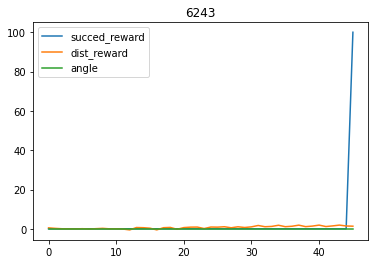

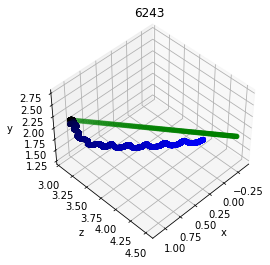

| eval  | E: 176 | S: 6243 | R: 32.7288
| train | E: 177 | S: 6243 | R: 31.5806 | D: 34.4 s | BR: 0.8543 | ALOSS: -14.4957 | CLOSS: 1.9334 | TLOSS: 0.0436 | TVAL: 0.0281 | AENT: -2.4499
| train | E: 178 | S: 6281 | R: 28.0991 | D: 102.7 s | BR: 0.8200 | ALOSS: -14.9695 | CLOSS: 1.5675 | TLOSS: 0.0460 | TVAL: 0.0279 | AENT: -2.3497
| train | E: 179 | S: 6306 | R: 31.2557 | D: 32.4 s | BR: 0.8234 | ALOSS: -16.0148 | CLOSS: 2.2620 | TLOSS: 0.0339 | TVAL: 0.0277 | AENT: -2.7772
| train | E: 180 | S: 6339 | R: 32.2224 | D: 41.6 s | BR: 0.8178 | ALOSS: -16.0492 | CLOSS: 1.0885 | TLOSS: 0.0330 | TVAL: 0.0275 | AENT: -2.8004
| train | E: 181 | S: 6368 | R: 30.2920 | D: 39.5 s | BR: 0.8328 | ALOSS: -15.5101 | CLOSS: 2.6717 | TLOSS: 0.0357 | TVAL: 0.0274 | AENT: -2.6959
| train | E: 182 | S: 6397 | R: 31.5966 | D: 38.2 s | BR: 0.8406 | ALOSS: -15.3317 | CLOSS: 1.8699 | TLOSS: 0.0309 | TVAL: 0.0272 | AENT: -2.8641
| train | E: 183 | S: 6425 | R: 33.3845 | D: 38.5 s | BR: 0.8328 | ALOSS: -15.3884 

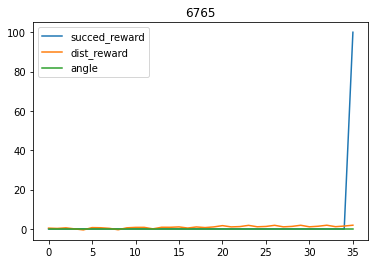

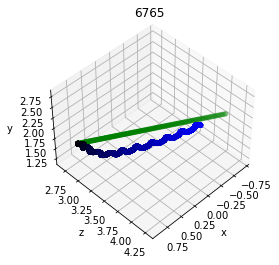

| eval  | E: 192 | S: 6765 | R: 33.5509
| train | E: 193 | S: 6765 | R: 31.2064 | D: 44.9 s | BR: 0.8493 | ALOSS: -13.8128 | CLOSS: 2.6418 | TLOSS: 0.0292 | TVAL: 0.0255 | AENT: -2.8557
| train | E: 194 | S: 6793 | R: 32.2956 | D: 78.5 s | BR: 0.8706 | ALOSS: -14.2245 | CLOSS: 2.6034 | TLOSS: 0.0286 | TVAL: 0.0254 | AENT: -2.8724
| train | E: 195 | S: 6824 | R: 32.3513 | D: 36.4 s | BR: 0.8612 | ALOSS: -15.4447 | CLOSS: 3.2308 | TLOSS: 0.0202 | TVAL: 0.0253 | AENT: -3.1991
| train | E: 196 | S: 6850 | R: 32.2297 | D: 32.5 s | BR: 0.8522 | ALOSS: -15.4472 | CLOSS: 2.9998 | TLOSS: 0.0209 | TVAL: 0.0252 | AENT: -3.1715
| train | E: 197 | S: 6880 | R: 30.0896 | D: 37.9 s | BR: 0.8475 | ALOSS: -16.4047 | CLOSS: 1.7966 | TLOSS: 0.0218 | TVAL: 0.0251 | AENT: -3.1314
| train | E: 198 | S: 6906 | R: 31.8082 | D: 32.2 s | BR: 0.8597 | ALOSS: -16.2212 | CLOSS: 1.5948 | TLOSS: 0.0180 | TVAL: 0.0250 | AENT: -3.2799
| train | E: 199 | S: 6936 | R: 32.9265 | D: 38.4 s | BR: 0.8230 | ALOSS: -15.9705 |

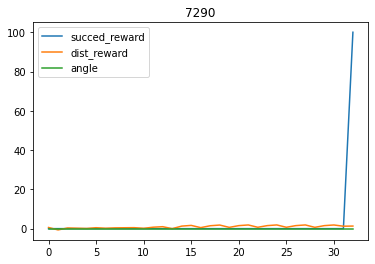

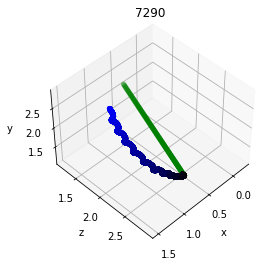

| eval  | E: 210 | S: 7290 | R: 30.0833
| train | E: 211 | S: 7290 | R: 32.8436 | D: 34.6 s | BR: 0.8769 | ALOSS: -15.6055 | CLOSS: 0.9656 | TLOSS: 0.0161 | TVAL: 0.0237 | AENT: -3.3197
| train | E: 212 | S: 7317 | R: 31.8496 | D: 72.7 s | BR: 0.8815 | ALOSS: -15.8212 | CLOSS: 1.1777 | TLOSS: 0.0219 | TVAL: 0.0236 | AENT: -3.0734
| train | E: 213 | S: 7351 | R: 32.4966 | D: 40.4 s | BR: 0.8560 | ALOSS: -16.0874 | CLOSS: 1.4268 | TLOSS: 0.0163 | TVAL: 0.0235 | AENT: -3.3070
| train | E: 214 | S: 7391 | R: 30.4736 | D: 46.8 s | BR: 0.8432 | ALOSS: -16.3535 | CLOSS: 1.2061 | TLOSS: 0.0185 | TVAL: 0.0234 | AENT: -3.2106
| train | E: 215 | S: 7420 | R: 29.7017 | D: 34.6 s | BR: 0.8490 | ALOSS: -15.9722 | CLOSS: 3.0257 | TLOSS: 0.0185 | TVAL: 0.0233 | AENT: -3.2056
| train | E: 216 | S: 7454 | R: 31.5247 | D: 39.4 s | BR: 0.8621 | ALOSS: -14.1731 | CLOSS: 1.4661 | TLOSS: 0.0210 | TVAL: 0.0232 | AENT: -3.0940
| train | E: 217 | S: 7484 | R: 32.9880 | D: 35.0 s | BR: 0.8644 | ALOSS: -15.5526 |

KeyboardInterrupt: 

In [29]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        agent.update(logger, step)  
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done,done)

## Evaluation and Test

In [30]:
def evaluate(theta):
        print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
        env.set_theta(theta)
        agent.reset()
        done = False
        episode_reward = 0
        infos = []
        actions = []
        while not done:
            with utils.eval_mode(agent):
                action = agent.act(obs, sample=False)
            actions.append(agent.actor.gate_network(torch.FloatTensor(obs).to(agent.device).unsqueeze(0)).cpu().detach().numpy())
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
        plot_infos(infos,title=str(theta),reward_fig_name="test_reward.png")
        env.plot3d(title=str(theta),fig_name = "test_traj.png")
        return actions

Evaluating episode  ....90
32.644803224645855


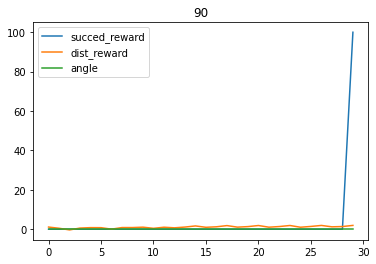

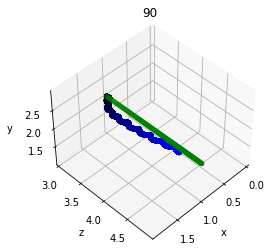

In [37]:
actions = evaluate(90)

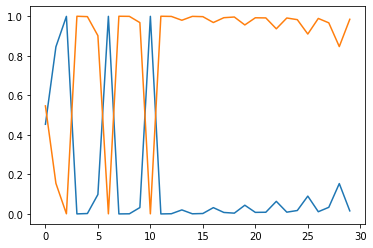

In [39]:
plt.figure()
aa = [a[0]for a in np.array(actions)]
plt.plot(aa)
plt.show()

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
from gym_fish.envs import FishEnv
env = gym.make('fish-v0', 
                  gpuId=gpuId,
                       path_json=str(Path("./py_data/jsons/paths/path_ss.json").resolve()),
                        couple_mode= couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=1.0,wr=0.0,wa=0.00,
                       rigid_json=rigid_json,
                   )
env.plot3d()

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0.)

t = 0.001
dt = 0.08

startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.goal_dir = path_orientation_begin
env.goal_pos = path_position_begin+env.goal_dir*1.0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.goal_dir = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition()- env.body_xyz
    env.goal_dir = env.goal_dir /np.linalg.norm(env.goal_dir)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
#     env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
#     env.goal_dir = env.goal_pos - env.body_xyz
#     env.goal_dir = env.goal_dir /np.linalg.norm(env.goal_dir)   
    env.stepSave(action,save_objects=False,save_fluid=False)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),vels)
plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()